In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# visualization, graph
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import matplotlib
import seaborn as sns


In [27]:
import os
Train_Path = '../data/train_images'
Test_Path = '../data/test_images'

print(len(os.listdir(Train_Path)))
print(len(os.listdir(Test_Path)))

from glob import glob

5546
3698


In [3]:
train_df = pd.read_csv('../data/train.csv')

In [4]:
train_df['File'] = train_df['Image_Label'].str.split('_').agg(lambda x: x[0])
train_df['Label'] = train_df['Image_Label'].str.split('_').agg(lambda x: x[1])
train_df.head(10)

Image_Label                                      EncodedPixels  \
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...   
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...   
2  0011165.jpg_Gravel                                                NaN   
3   0011165.jpg_Sugar                                                NaN   
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...   
5  002be4f.jpg_Flower  1339279 519 1340679 519 1342079 519 1343479 51...   
6  002be4f.jpg_Gravel                                                NaN   
7   002be4f.jpg_Sugar  67495 350 68895 350 70295 350 71695 350 73095 ...   
8    0031ae9.jpg_Fish  3510 690 4910 690 6310 690 7710 690 9110 690 1...   
9  0031ae9.jpg_Flower  2047 703 3447 703 4847 703 6247 703 7647 703 9...   

          File   Label  
0  0011165.jpg    Fish  
1  0011165.jpg  Flower  
2  0011165.jpg  Gravel  
3  0011165.jpg   Sugar  
4  002be4f.jpg    Fish  
5  002be4f.jpg  Flower  
6  002be4f.jpg  Gravel  
7  002be4f.jpg   Sugar  
8  0031ae9.jpg    Fish  
9  0031ae9.jpg  Flower

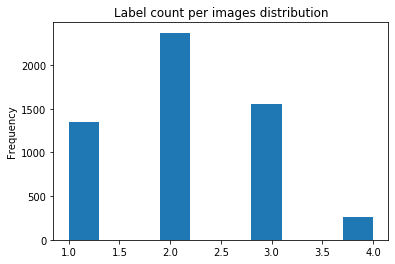

In [5]:
train_df.groupby('File')['EncodedPixels'].count().plot(kind='hist', title='Label count per images distribution')

(-1.1167092209878937,
 1.111167230316861,
 -1.1288767869661804,
 1.1013750850936277)

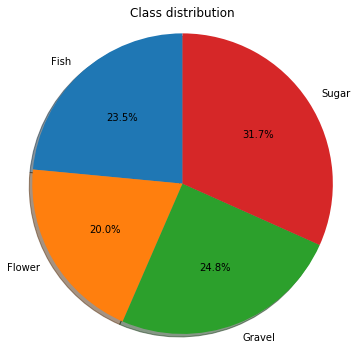

In [6]:
label_list = train_df['Label'].unique().tolist()
label_count = []
for label in label_list:
    label_count.append(train_df.loc[train_df['Label']==label, 'EncodedPixels'].count())

fig, ax = plt.subplots(figsize=(6,6))
ax.pie(label_count, labels=label_list, autopct='%1.1f%%', shadow=True, startangle=90)
ax.set_title('Class distribution')
ax.axis('equal')

In [36]:
import cv2
from PIL import Image
import imageio

from imgaug import augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage 
import imgaug.imgaug

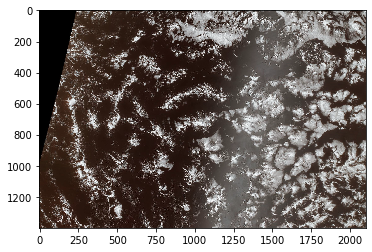

In [28]:
img = cv2.imread(os.path.join(Train_Path, train_df['File'][0]))
plt.imshow(img)

In [29]:
train_df_tmp = train_df.dropna()
train_df_tmp.reset_index(drop=True, inplace=True)
train_df_tmp = train_df_tmp.groupby('File')['Label'].sum()
train_df_tmp.head(10)

File
0011165.jpg         FishFlower
002be4f.jpg    FishFlowerSugar
0031ae9.jpg    FishFlowerSugar
0035239.jpg       FlowerGravel
003994e.jpg    FishGravelSugar
00498ec.jpg             Gravel
006bf7c.jpg          FishSugar
006c5a6.jpg          FishSugar
008233e.jpg              Sugar
008a5ff.jpg          FishSugar
Name: Label, dtype: object

Text(0.5, 1.0, 'Class distribution2')

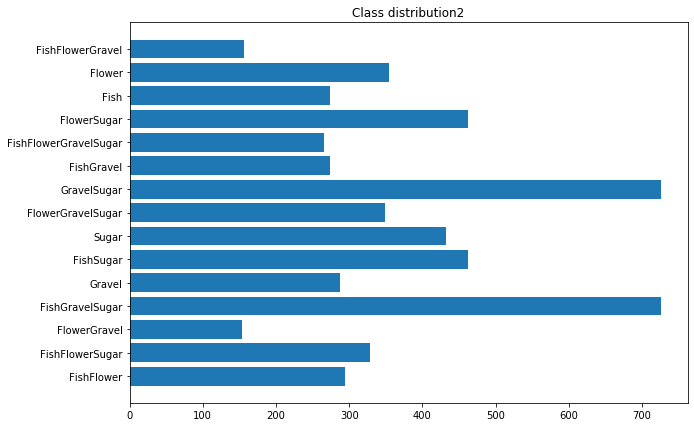

In [30]:
label = train_df_tmp.unique()
label_cnt = np.array([(train_df_tmp[train_df_tmp==ele]).count() for ele in label])
fig, ax = plt.subplots(figsize=(10,7))
ax.barh(label, label_cnt)
ax.set_title('Class distribution2')

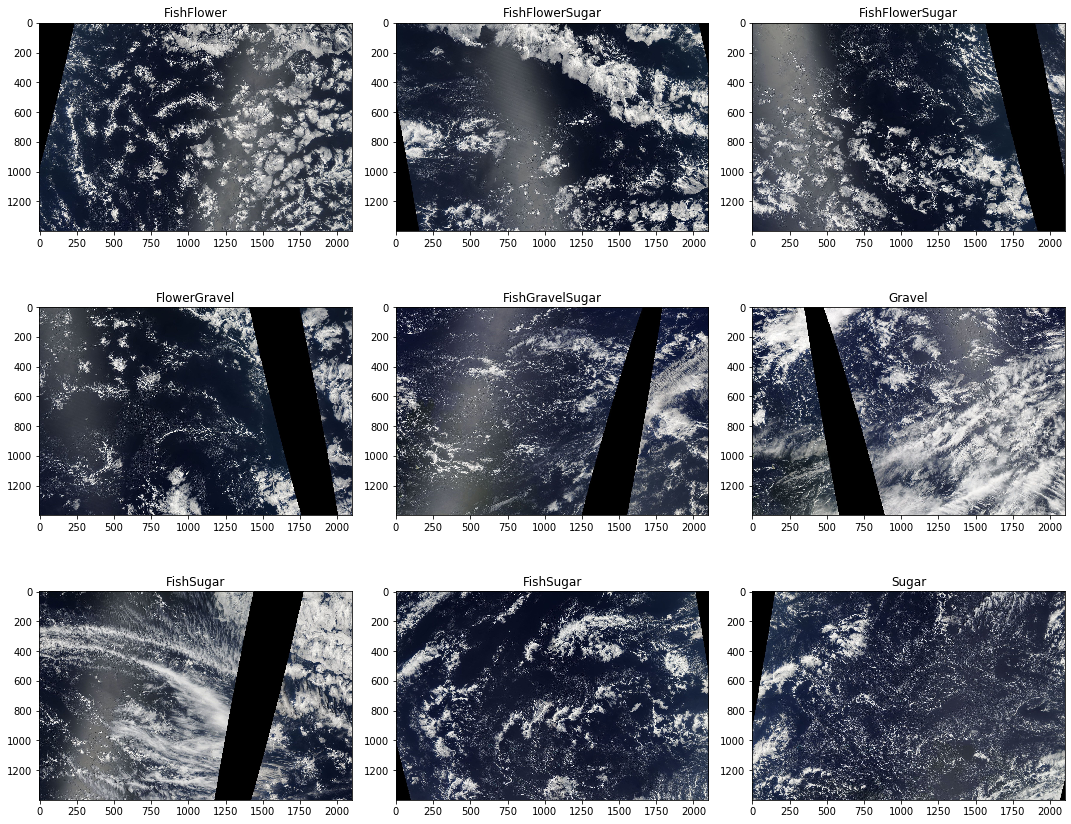

In [31]:
def display_samples(path, df, columns=3, rows=3):
    imgid = df.index
    
    fig=plt.figure(figsize=(5*columns, 4*rows))
    for i in range(columns*rows): 
        img = cv2.imread(os.path.join(path, f'{imgid[i]}'))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label = df[i]

        fig.add_subplot(rows, columns, i+1)
        plt.title(label)
        plt.imshow(img)

    plt.tight_layout()

display_samples(Train_Path, train_df_tmp)

In [32]:
def np_resize(img, input_shape):
    height, width = input_shape
    return cv2.resize(img, (width, height))
    
def mask2rle(img):
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask = np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

def rle_decode(mask_rle, shape=(1400, 2100)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')  # Needed to align to RLE direction

def build_masks(rles, input_shape, reshape=None):
    depth = len(rles)
    if reshape is None:
        masks = np.zeros((*input_shape, depth))
    else:
        masks = np.zeros((*reshape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            if reshape is None:
                masks[:, :, i] = rle2mask(rle, input_shape)
            else:
                mask = rle2mask(rle, input_shape)
                reshaped_mask = np_resize(mask, reshape)
                masks[:, :, i] = reshaped_mask
    
    return masks

def build_rles(masks, reshape=None):
    width, height, depth = masks.shape
    rles = []
    
    for i in range(depth):
        mask = masks[:, :, i]
        
        if reshape:
            mask = mask.astype(np.float32)
            mask = np_resize(mask, reshape).astype(np.int64)
        
        rle = mask2rle(mask)
        rles.append(rle)
        
    return rles

In [34]:
def draw_labels(image, points):
    '''
    Function to add labels to the image.
    '''
    for x, y, label in points:
        image = imgaug.imgaug.draw_text(image, x, y, label, color=(255, 255, 255), size=50)
    return image

def get_mask(img_id, line_id, im_df, shape = (1400, 2100)):
    '''
    Function to visualize the image and the mask.
    RETURNS:
        np_mask - numpy segmentation map
    '''
    
    # convert rle to mask
    rle = im_df.loc[im_df['File']==img_id, 'EncodedPixels'][line_id]
    if rle != -1:
        np_mask = rle2mask(rle, shape)
#         np_mask = np.clip(np_mask, 0, 1)
    else:
        # empty mask
        np_mask = np.zeros((shape[0],shape[1]), dtype=np.uint8)
        
    return np_mask

def visualize_image_with_mask(img_id, df, df_cpy):
    
    # set df info
    im_df = df.loc[df['File']==img_id]
    im_df.reset_index(drop=True, inplace=True)
    
    # replace null values with '-1'
    im_df.fillna(-1, inplace=True)
    
    # open the image
    image=cv2.imread(os.path.join(Train_Path, img_id))
    
    segmap = np.zeros((image.shape[0], image.shape[1]), dtype=np.int32)
    points = []
    for line_id in range(4):
        # get segmentation mask
        np_mask = get_mask(img_id, line_id, im_df)
        # for draw label
        if np.sum(np_mask) > 0:
            x,y = 0,0
            x,y = np.argwhere(np_mask==1)[0]
            points.append((x, y, im_df['Label'][line_id]))

        # for segmentation map
        segmap = np.where(np_mask == 1, line_id+1, segmap)
    
    # create segmentation map
    segmap = SegmentationMapsOnImage(segmap, image.shape, nb_classes=5)
    
    # draw the map on image
    image = np.asarray(segmap.draw_on_image(np.asarray(image))).reshape(np.asarray(image).shape)
    
    # draw text(label)
    image = draw_labels(image, points)
        
    # visualize the image and map
    side_by_side = np.hstack([
        image
    ])
    
    return side_by_side

/usr/local/lib/python3.6/dist-packages/imgaug/imgaug.py:107: DeprecationWarning: Providing nb_classes to SegmentationMapsOnImage is no longer necessary and hence deprecated. The argument is ignored and can be safely removed.
  warn(msg, category=DeprecationWarning, stacklevel=stacklevel)


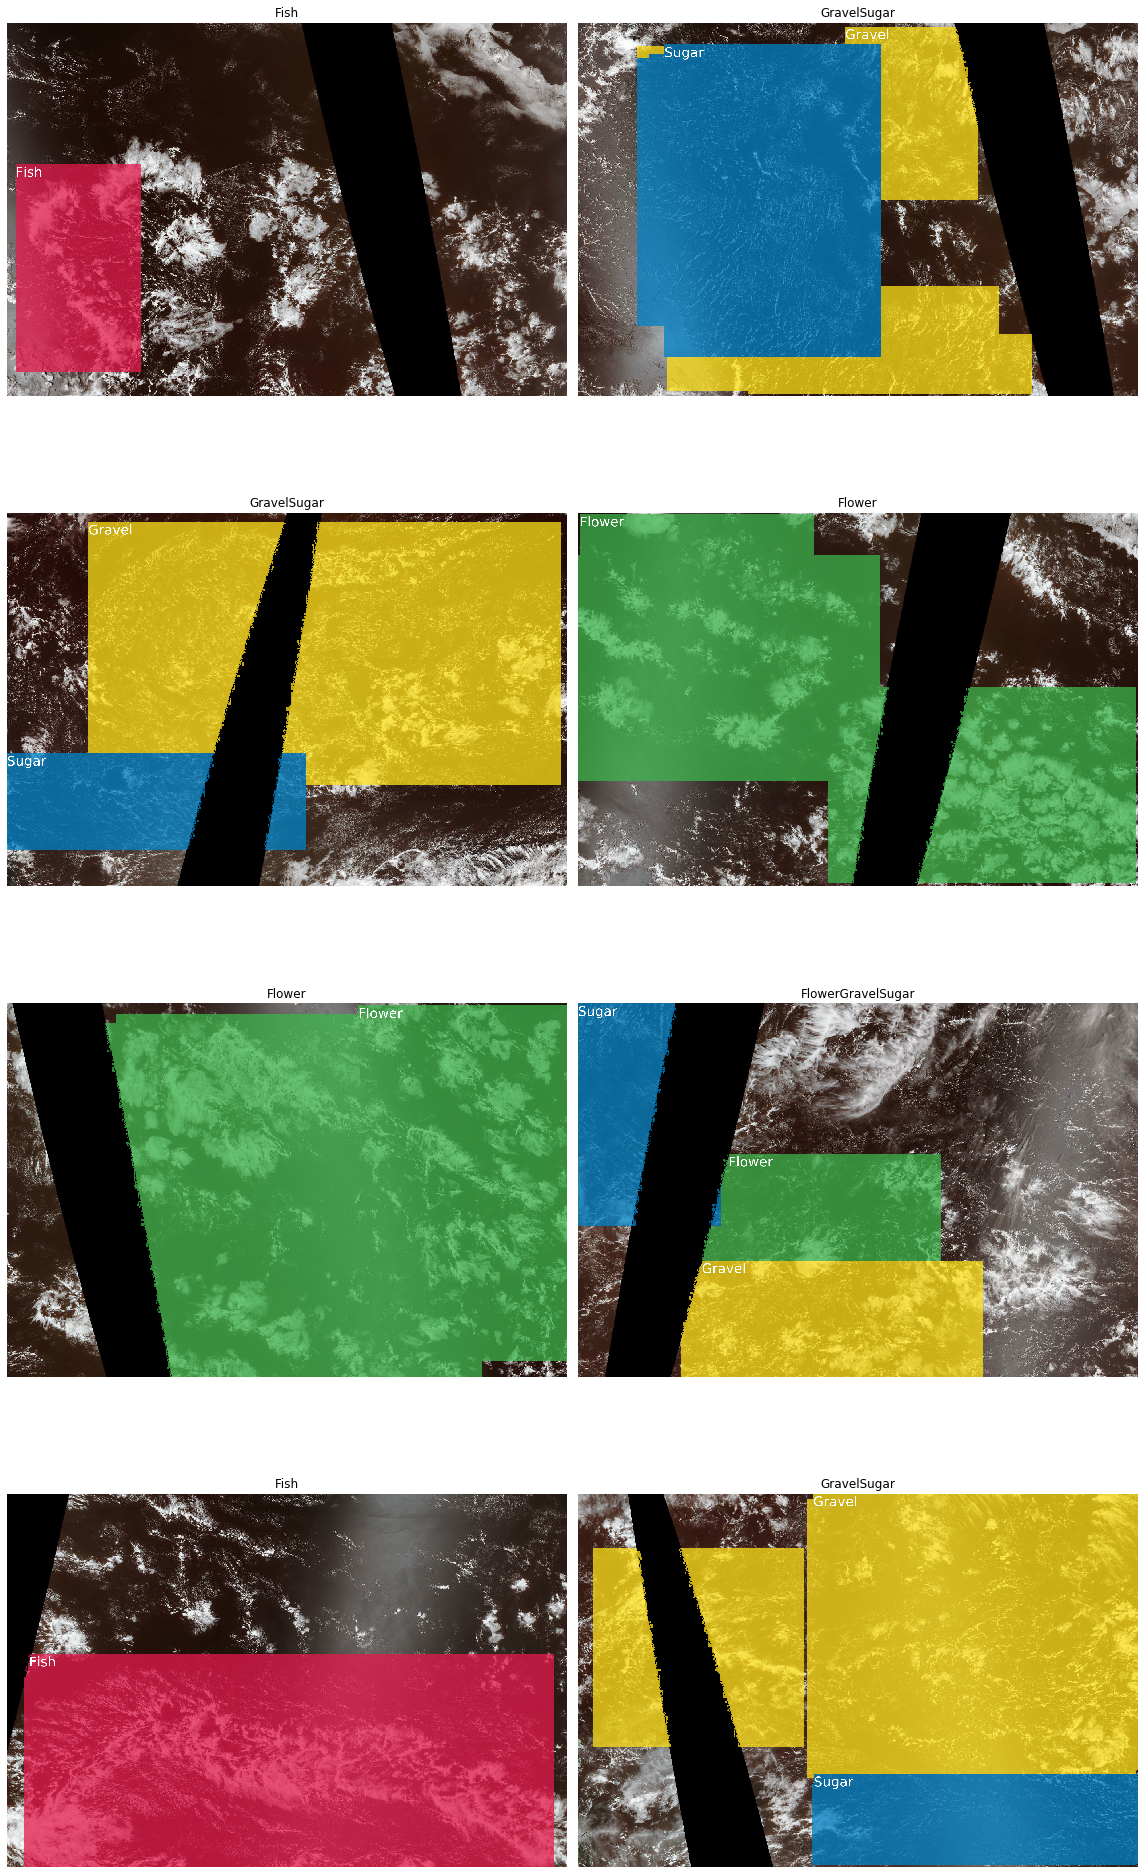

In [37]:
train_fns = train_df_tmp.index

columns, rows = 2, 4
fig=plt.figure(figsize=(8*columns, 7*rows))
for i in range(columns*rows): 
    # generate random index for an image
#     np.random.seed(2019)
    rnd_index = np.random.choice(range(len(train_fns)))
    
    img_id = train_fns[rnd_index]
    label = train_df_tmp[img_id]
    
    seg_img = visualize_image_with_mask(img_id, train_df, train_df_tmp)
    
    fig.add_subplot(rows, columns, i+1)
    plt.axis('off')
    plt.title(label)
    plt.imshow(seg_img)

plt.tight_layout()